## IGO15488_1_2 combined
8/29/2024 - Data generated from Exercise-p53 mice KPT. From Klavdija, aligned by Jason with CellRanger-v6.1.1
Analyze global run on cellranger v6 data and create h5_ad files for further analysis

8/25/2025 - Rerun with updated libraries for coherence

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
#plt.rcParams['figure.figsize'] = (3,4)

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [4]:
#Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
adata1 = anndata.read('../IGO15488_1/write/allmice-tumor-KPT1.h5ad')
adata2 = anndata.read('../IGO15488_2/write/allmice-tumor-KPT2.h5ad')

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
adata = adata1.concatenate(adata2, join='inner', batch_categories=['lane1', 'lane2'])
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_70123/2401071598.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata2, join='inner', batch_categories=['lane1', 'lane2'])


## Now select only KP Rosa26-tdTomato/+ mice

In [7]:
adata.obs.Classification.value_counts(sort=False)

Classification
BB1053_B0314    806
BD1446_B0315    230
BD1959_B0303    858
BD1970_B0313    142
BD1971_B0313    298
BD1976_B0302    755
BE1864_B0311    210
BF1106_B0311    705
BF1443_B0301    369
BF1448_B0304    311
BF1449_B0305    752
BF1451_B0305    259
BF1556_B0302    261
BF1585_B0312      4
BF1588_B0312     77
BF1595_B0304    223
BF1596_B0301     60
BF1607_B0303    239
Name: count, dtype: int64

In [8]:
adata = adata[adata.obs.Classification.isin(['BF1607_B0303','BD1959_B0303','BB1053_B0314']),:]

## Look at lane and batch statistics

In [9]:
adata.obs.Classification.value_counts()

Classification
BD1959_B0303    858
BB1053_B0314    806
BF1607_B0303    239
Name: count, dtype: int64

In [10]:
adata.obs[['batch','Classification']].value_counts()

batch  Classification
lane2  BD1959_B0303      858
       BB1053_B0314      632
lane1  BF1607_B0303      239
       BB1053_B0314      174
Name: count, dtype: int64

## Set group

In [11]:
adata.obs['Group'] = 'KPT'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_70123/241905987.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'KPT'


## Set highly variable genes

In [12]:
sc.pp.highly_variable_genes(adata, batch_key='batch')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [13]:
adata.var.highly_variable = adata.var.highly_variable_intersection

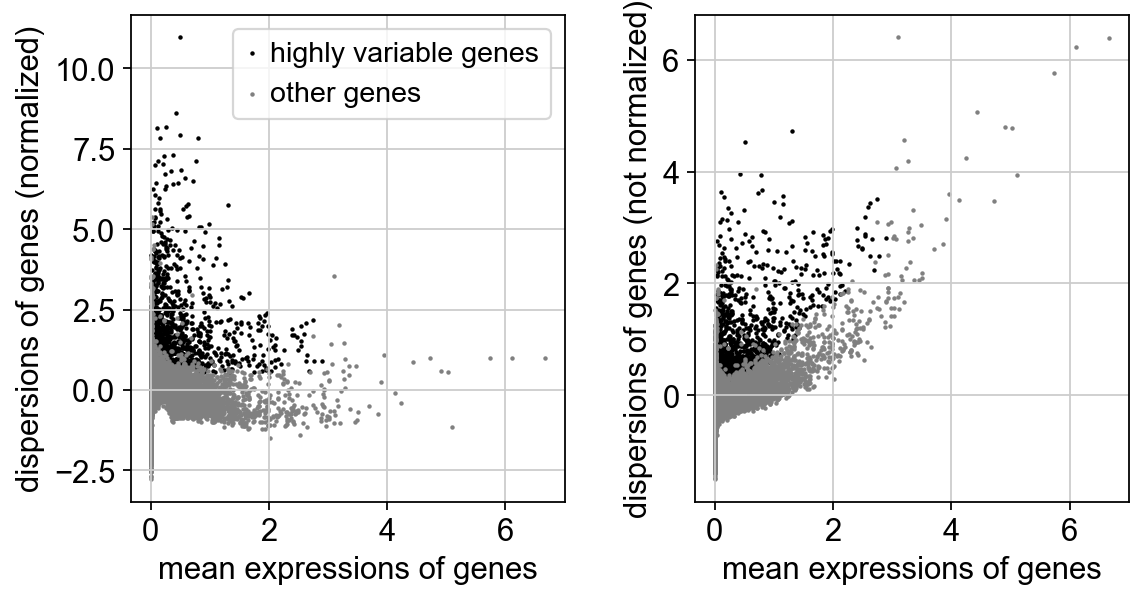

In [14]:
sc.pl.highly_variable_genes(adata)

In [15]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['tagBFP'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_70123/850513103.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_70123/8505131

In [16]:
adata.write('write/allmice-IGO15488_combined.h5ad', compression='gzip')